In [1]:
!pip install matplotlib numpy Pillow tqdm opencv-python torch torchvision albumentations

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [3]:
## Data Loading and Augmentation

In [4]:
class BarnacleDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_files = sorted(glob(os.path.join(data_dir, 'imgs', '*.png')))
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = img_path.replace('imgs', 'masks')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask / 255.0
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

In [5]:
## U-Net Model Definition

In [6]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
## U-Net Model Definition

In [8]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
## Data Preparation and Visualization

In [10]:
# Data augmentation

# Create datasets and dataloaders
train_dataset = BarnacleDataset('../data/tiles/train', transform=False)
val_dataset = BarnacleDataset('../data/tiles/val')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Training samples: 358
Validation samples: 90


In [11]:
## Debugging through visualization and analysis of the empty masks

Mask unique values: [0. 1.], sum: 1561.0
Image min: 0.0 max: 0.88235295 mean: 0.3217271


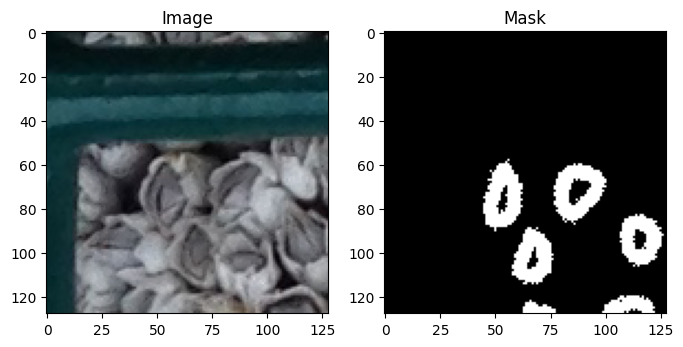

Mask unique values: [0. 1.], sum: 3321.0
Image min: 0.0 max: 0.8745098 mean: 0.33661366


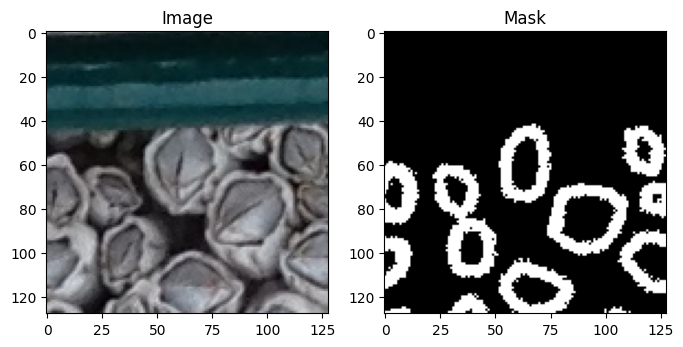

Mask unique values: [0. 1.], sum: 3587.0
Image min: 0.0 max: 0.8784314 mean: 0.36143616


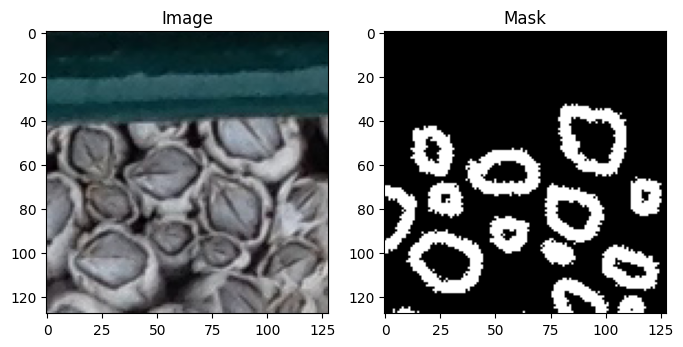

Mask unique values: [0. 1.], sum: 3044.0
Image min: 0.0 max: 0.8784314 mean: 0.35875142


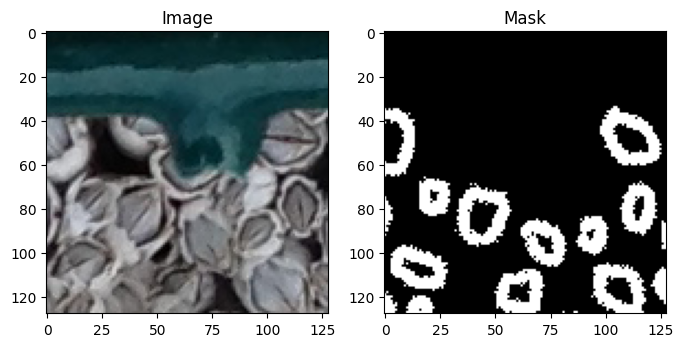

Mask unique values: [0. 1.], sum: 3819.0
Image min: 0.0 max: 0.87058824 mean: 0.36682522


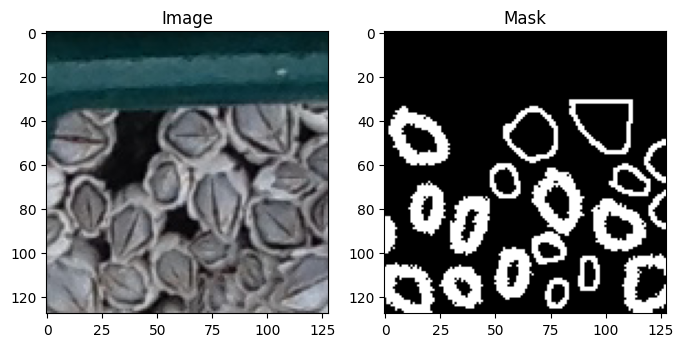

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    img, mask = train_dataset[i]
    img_np = img.permute(1,2,0).numpy() if hasattr(img, 'permute') else np.array(img)
    mask_np = mask.squeeze().numpy() if hasattr(mask, 'numpy') else np.array(mask)
    print(f"Mask unique values: {np.unique(mask_np)}, sum: {mask_np.sum()}")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow((img_np * 255).astype(np.uint8))
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    print("Image min:", img_np.min(), "max:", img_np.max(), "mean:", img_np.mean())
    plt.show()

In [13]:
   empty = 0
   for i in range(len(train_dataset)):
       _, mask = train_dataset[i]
       mask_np = mask.squeeze().numpy() if hasattr(mask, 'numpy') else np.array(mask)
       if np.sum(mask_np) == 0:
           empty += 1
   print(f"Empty masks: {empty} / {len(train_dataset)}")

Empty masks: 0 / 358


In [14]:
## Training and Validation Functions

In [15]:
def dice_score(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection) / (union + 1e-6)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    for imgs, masks in tqdm(loader, desc='Training'):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc='Validation'):
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

In [16]:
## Model Training

In [17]:
import os
os.makedirs('../models', exist_ok=True)
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
train_losses, val_losses, train_dices, val_dices = [], [], [], []
best_val_dice = 0
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), '../models/best_barnacle_unet.pth')
        print(f'New best model saved! Dice: {val_dice:.4f}')
    if epoch > 5 and val_dice < 0.1:
        print('Early stopping due to poor performance')
        break


Epoch 1/20


Validation: 100%|█████████████████████| 12/12 [00:03<00:00,  3.08it/s]


Train Loss: 0.5052, Train Dice: 0.2904
Val Loss: 0.4388, Val Dice: 0.1662
New best model saved! Dice: 0.1662

Epoch 2/20


Validation: 100%|█████████████████████| 12/12 [00:04<00:00,  2.96it/s]


Train Loss: 0.4048, Train Dice: 0.3239
Val Loss: 0.3953, Val Dice: 0.3277
New best model saved! Dice: 0.3277

Epoch 3/20


Validation: 100%|█████████████████████| 12/12 [00:03<00:00,  3.57it/s]


Train Loss: 0.3592, Train Dice: 0.4890
Val Loss: 0.3465, Val Dice: 0.5196
New best model saved! Dice: 0.5196

Epoch 4/20


Validation: 100%|█████████████████████| 12/12 [00:03<00:00,  3.06it/s]


Train Loss: 0.3293, Train Dice: 0.5624
Val Loss: 0.4409, Val Dice: 0.3198

Epoch 5/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Train Loss: 0.3148, Train Dice: 0.5791
Val Loss: 0.2988, Val Dice: 0.5607
New best model saved! Dice: 0.5607

Epoch 6/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Train Loss: 0.2893, Train Dice: 0.6255
Val Loss: 0.3007, Val Dice: 0.5973
New best model saved! Dice: 0.5973

Epoch 7/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.45it/s]


Train Loss: 0.2745, Train Dice: 0.6453
Val Loss: 0.3115, Val Dice: 0.6141
New best model saved! Dice: 0.6141

Epoch 8/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Train Loss: 0.2592, Train Dice: 0.6663
Val Loss: 0.2685, Val Dice: 0.5987

Epoch 9/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.52it/s]


Train Loss: 0.2413, Train Dice: 0.6932
Val Loss: 0.2608, Val Dice: 0.5843

Epoch 10/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Train Loss: 0.2276, Train Dice: 0.7090
Val Loss: 0.2612, Val Dice: 0.6334
New best model saved! Dice: 0.6334

Epoch 11/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Train Loss: 0.2111, Train Dice: 0.7357
Val Loss: 0.2486, Val Dice: 0.6404
New best model saved! Dice: 0.6404

Epoch 12/20


Validation: 100%|█████████████████████| 12/12 [00:03<00:00,  3.80it/s]


Train Loss: 0.1937, Train Dice: 0.7628
Val Loss: 0.2446, Val Dice: 0.6391

Epoch 13/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Train Loss: 0.1800, Train Dice: 0.7832
Val Loss: 0.2416, Val Dice: 0.6618
New best model saved! Dice: 0.6618

Epoch 14/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  4.15it/s]


Train Loss: 0.1658, Train Dice: 0.8033
Val Loss: 0.2346, Val Dice: 0.6717
New best model saved! Dice: 0.6717

Epoch 15/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  4.98it/s]


Train Loss: 0.1504, Train Dice: 0.8284
Val Loss: 0.2259, Val Dice: 0.6560

Epoch 16/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.01it/s]


Train Loss: 0.1398, Train Dice: 0.8416
Val Loss: 0.2381, Val Dice: 0.6525

Epoch 17/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.12it/s]


Train Loss: 0.1295, Train Dice: 0.8539
Val Loss: 0.2253, Val Dice: 0.6553

Epoch 18/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Train Loss: 0.1207, Train Dice: 0.8659
Val Loss: 0.2212, Val Dice: 0.6791
New best model saved! Dice: 0.6791

Epoch 19/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  4.98it/s]


Train Loss: 0.1083, Train Dice: 0.8841
Val Loss: 0.2206, Val Dice: 0.6929
New best model saved! Dice: 0.6929

Epoch 20/20


Validation: 100%|█████████████████████| 12/12 [00:02<00:00,  5.04it/s]

Train Loss: 0.1023, Train Dice: 0.8904
Val Loss: 0.2173, Val Dice: 0.6921


In [18]:
## Training Curves

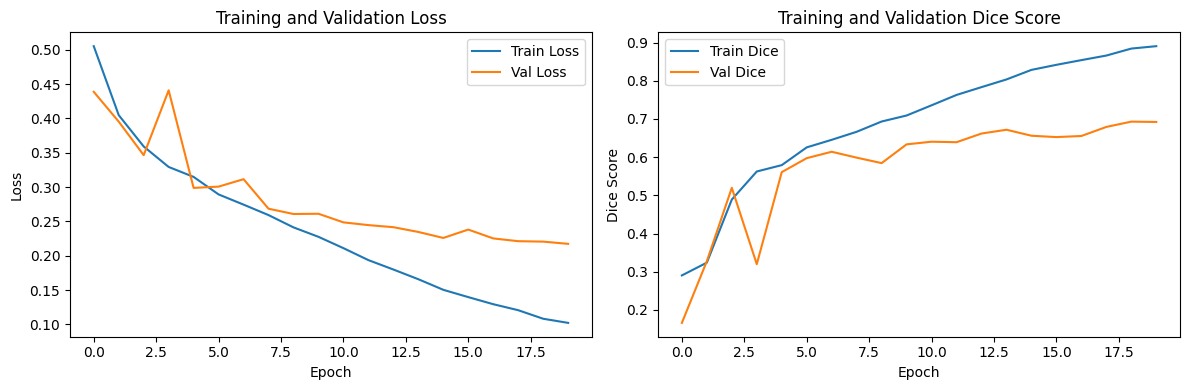

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
## Sample Predictions on Validation Data

/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_44850/3639788854.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/b

Final Dice Score: 0.3500


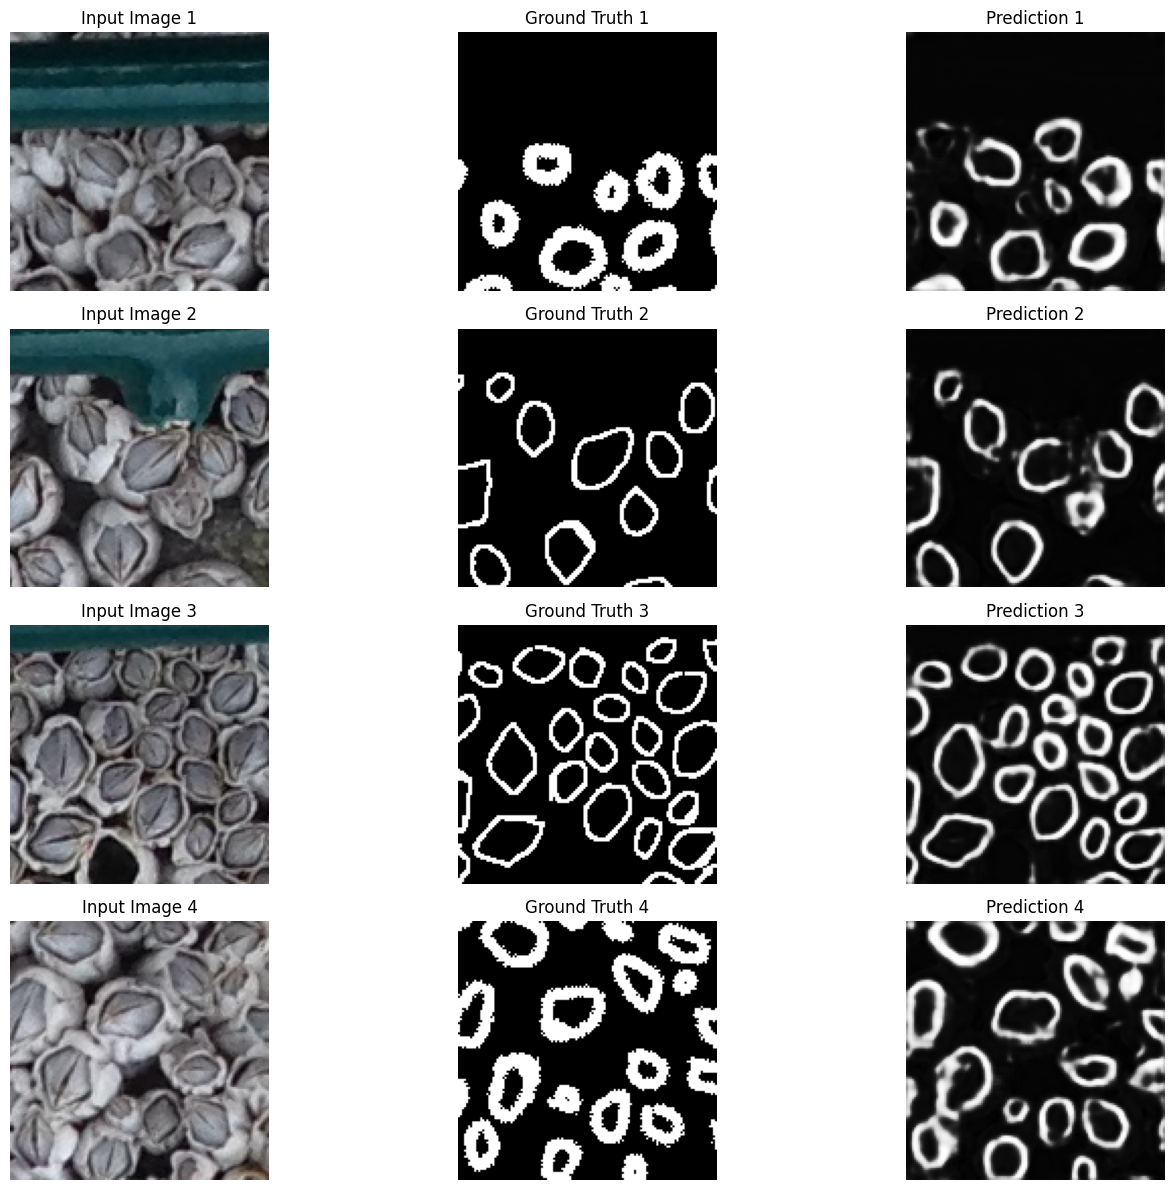

In [21]:
model.load_state_dict(torch.load('../models/best_barnacle_unet.pth'))
model.eval()
test_batch = next(iter(val_loader))
test_imgs, test_masks = test_batch
with torch.no_grad():
    test_imgs = test_imgs.to(device)
    predictions = model(test_imgs)
    predictions = torch.sigmoid(predictions)
final_dice = dice_score(predictions, test_masks.to(device)).item()
print(f'Final Dice Score: {final_dice:.4f}')
plt.figure(figsize=(15, 12))
for i in range(4):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(test_imgs[i].cpu().permute(1, 2, 0))
    plt.title(f'Input Image {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+2)
    plt.imshow(test_masks[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+3)
    plt.imshow(predictions[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
## Inference on New Images

In [23]:
def predict_full_image(model, img_path, device, out_threshold=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        mask = (output > out_threshold).float()
    return mask.squeeze().cpu().numpy()
# Example usage:
# pred_mask = predict_full_image(model, 'path/to/new_image.png', device)
# plt.imshow(pred_mask, cmap='gray')
# plt.show()

In [ ]:
## Testing on the Unseen Images

/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_44850/2278165631.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/b


Processing ../data/imgs/test/unseen_img1.png...


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


  Image size: 3264x2448
  Processing with 512x512 tiles, 64 overlap
  Processed 35 tiles
  Saved prediction as unseen_prediction_1.png
  Saved probability map as unseen_probability_1.png
  Detected 394,783 barnacle pixels (4.94% of image)

Processing ../data/imgs/test/unseen_img2.png...
  Image size: 500x500
  Processing with 512x512 tiles, 64 overlap
  Processed 1 tiles
  Saved prediction as unseen_prediction_2.png
  Saved probability map as unseen_probability_2.png
  Detected 25,914 barnacle pixels (10.37% of image)


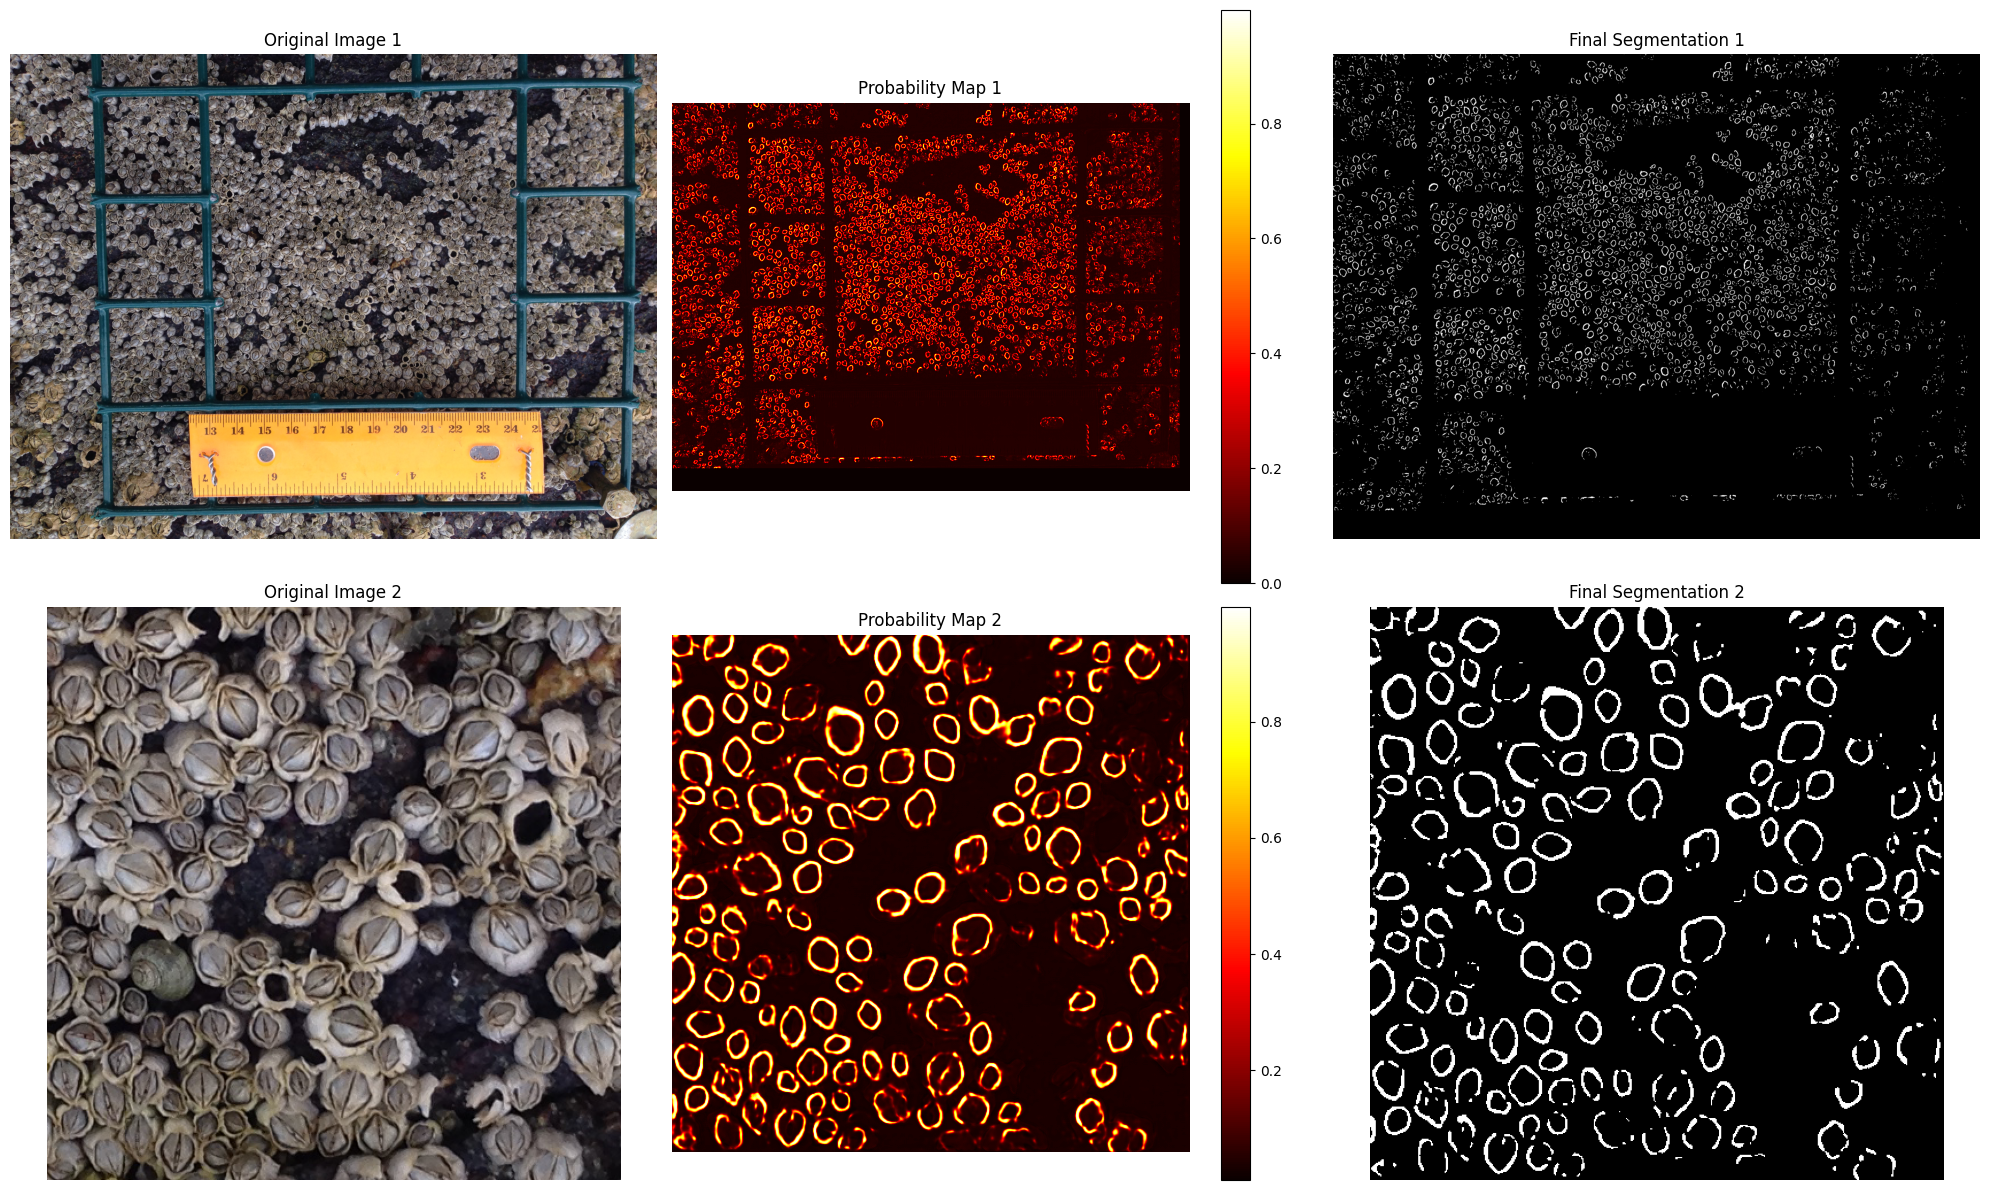


Testing complete! Check the saved files:
- unseen_prediction_1.png, unseen_prediction_2.png: Final segmentations
- unseen_probability_1.png, unseen_probability_2.png: Probability maps
- unseen_predictions.png: Combined visualization


In [24]:
# Copy this entire code block as a new cell in your Jupyter notebook

## Testing on Unseen Images

# Load the best trained model
model.load_state_dict(torch.load('../models/best_barnacle_unet.pth', map_location=device))
model.eval()

# Function to predict on full images with tiling for large images
def predict_large_image(model, img_path, device, tile_size=512, overlap=64, out_threshold=0.5):
    """
    Predict on large images by tiling them to avoid memory issues
    """
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    print(f"  Image size: {w}x{h}")
    print(f"  Processing with {tile_size}x{tile_size} tiles, {overlap} overlap")
    
    # Create output mask
    output_mask = np.zeros((h, w), dtype=np.float32)
    count_mask = np.zeros((h, w), dtype=np.float32)
    
    stride = tile_size - overlap
    
    # Process image in tiles
    tile_count = 0
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            # Extract tile
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)
            
            # Handle edge cases
            if y_end - y < tile_size // 2 or x_end - x < tile_size // 2:
                continue
                
            tile = img[y:y_end, x:x_end]
            
            # Pad if necessary
            if tile.shape[:2] != (tile_size, tile_size):
                padded_tile = np.zeros((tile_size, tile_size, 3), dtype=np.uint8)
                padded_tile[:tile.shape[0], :tile.shape[1]] = tile
                tile = padded_tile
            
            # Convert to tensor
            tile_tensor = torch.from_numpy(tile.transpose(2, 0, 1)).float() / 255.0
            tile_tensor = tile_tensor.unsqueeze(0).to(device)
            
            # Predict
            with torch.no_grad():
                output = model(tile_tensor)
                output = torch.sigmoid(output)
                pred_tile = output.squeeze().cpu().numpy()
            
            # Add to output mask (with overlap handling)
            output_mask[y:y_end, x:x_end] += pred_tile[:y_end-y, :x_end-x]
            count_mask[y:y_end, x:x_end] += 1
            tile_count += 1
    
    print(f"  Processed {tile_count} tiles")
    
    # Average overlapping regions
    output_mask = np.divide(output_mask, count_mask, out=np.zeros_like(output_mask), where=count_mask > 0)
    
    # Apply threshold
    final_mask = (output_mask > out_threshold).astype(np.uint8) * 255
    
    return final_mask, output_mask

# Test on unseen images
test_images = ['../data/imgs/test/unseen_img1.png', '../data/imgs/test/unseen_img2.png']

plt.figure(figsize=(20, 12))

for i, img_path in enumerate(test_images):
    print(f"\nProcessing {img_path}...")
    
    if not os.path.exists(img_path):
        print(f"  Error: File not found: {img_path}")
        continue
    
    # Load original image for display
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Predict
    final_mask, prob_mask = predict_large_image(model, img_path, device)
    
    if final_mask is not None:
        # Display results
        plt.subplot(2, 3, i*3 + 1)
        plt.imshow(img_rgb)
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        
        plt.subplot(2, 3, i*3 + 2)
        plt.imshow(prob_mask, cmap='hot')
        plt.title(f'Probability Map {i+1}')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, i*3 + 3)
        plt.imshow(final_mask, cmap='gray')
        plt.title(f'Final Segmentation {i+1}')
        plt.axis('off')
        
        # Save results
        cv2.imwrite(f'unseen_prediction_{i+1}.png', final_mask)
        cv2.imwrite(f'unseen_probability_{i+1}.png', (prob_mask * 255).astype(np.uint8))
        
        print(f"  Saved prediction as unseen_prediction_{i+1}.png")
        print(f"  Saved probability map as unseen_probability_{i+1}.png")
        
        # Print statistics
        barnacle_pixels = np.sum(final_mask > 0)
        total_pixels = final_mask.size
        barnacle_percentage = (barnacle_pixels / total_pixels) * 100
        print(f"  Detected {barnacle_pixels:,} barnacle pixels ({barnacle_percentage:.2f}% of image)")
    else:
        print(f"  Failed to process {img_path}")

plt.tight_layout()
plt.savefig('unseen_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTesting complete! Check the saved files:")
print("- unseen_prediction_1.png, unseen_prediction_2.png: Final segmentations")
print("- unseen_probability_1.png, unseen_probability_2.png: Probability maps")
print("- unseen_predictions.png: Combined visualization")